# AutoKeras implementation 

This notebook uses Autokeras, an automated machine learning library built upon Tensorflow and Keras. The goal of AutoKeras is to make machine learning accessible for everyone.

This example takes a real-life dataset [dogs vs cat](https://www.kaggle.com/c/dogs-vs-cats/data) and tries to train a well working image classifier without a user who decides which layers to use.

Please make sure that your driver configuration is correct (using Nvidia CUDA and cuDNN) and that the library makes its calculations on a GPU. Note that this code is written for AutoKeras v1.0.2 and may be updated for future versions.

Author: Robbe Decorte

## Global imports and declarations

In [2]:
import pandas as pd
import numpy as np
import autokeras as ak

MAX_TRIES=5
SIZE=64
OUTPUT_NAME="autokeras-model-5"

## Verify GPU status

In [70]:
# Use the Keras GPU package
# conda install -c anaconda keras-gpu
from tensorflow.python.client import device_lib

In [71]:
# Show detailed information about the usable devices for Tensoflow
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7502211016056982511
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3142752665
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12990106037986299612
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [72]:
# Only request device names
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

['/device:CPU:0', '/device:GPU:0']


## Shuffle data and convert to numpy array

In [18]:
import os
from tqdm import tqdm
from PIL import Image
from random import shuffle

INPUT_PATH="data/train/"

In [20]:
def get_label(file):
    class_label = file.split('.')[0]
    if class_label == 'dog': label_vector = 0
    elif class_label == 'cat': label_vector = 1
    return label_vector

In [21]:
def get_data():
    data = []
    files = os.listdir(INPUT_PATH)
    for image in tqdm(files):
        
        label_vector = get_label(image)

        img = Image.open(INPUT_PATH + image).convert('L')
        img = img.resize((SIZE,SIZE))
        
        data.append([np.asarray(img),np.array(label_vector)])
        
    shuffle(data)
    return data

In [22]:
data = get_data()

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [01:54<00:00, 217.91it/s]


In [23]:
# Save the data as a numpy array
np.save('data/images_shuffled.npy', data)

## Data preprocessing and split to test and train

In [3]:
data = np.load('data/images_shuffled.npy', allow_pickle=True)

# Split the labled data in train (20000 images) and test (5000 images)
train = data[:20000]
test = data[20000:]

print("Training dataset contains %d items" % len(train))
print("Testing dataset contains %d items" % len(test))

Training dataset contains 20000 items
Testing dataset contains 5000 items


In [4]:
x_train = np.array([data[0] for data in train], 'float32')
x_test = np.array([data[0] for data in test], 'float32')
y_train = [data[1] for data in train]
y_test = [data[1] for data in test]

In [5]:
x_train = np.array(x_train).reshape(-1,SIZE,SIZE,1)
x_test = np.array(x_test).reshape(-1,SIZE,SIZE,1)

x_train /= 255
x_test /= 255

y_train = np.array(y_train)
y_test = np.array(y_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(20000, 64, 64, 1)
(20000,)
(5000, 64, 64, 1)
(5000,)


## Training and model evaluation

In [52]:
# Init image classifier.
clf = ak.ImageClassifier(max_trials=MAX_TRIES, name=OUTPUT_NAME)
# Feed the image classifier with training data.
clf.fit(x_train,y_train, verbose=2)

Train for 500 steps, validate for 125 steps
Epoch 1/1000
500/500 - 28s - loss: 0.6016 - accuracy: 0.6668 - val_loss: 0.5483 - val_accuracy: 0.7207
Epoch 2/1000
500/500 - 28s - loss: 0.5064 - accuracy: 0.7564 - val_loss: 0.5351 - val_accuracy: 0.7322
Epoch 3/1000
500/500 - 27s - loss: 0.4621 - accuracy: 0.7840 - val_loss: 0.5034 - val_accuracy: 0.7607
Epoch 4/1000
500/500 - 27s - loss: 0.4289 - accuracy: 0.8006 - val_loss: 0.5038 - val_accuracy: 0.7582
Epoch 5/1000
500/500 - 27s - loss: 0.4018 - accuracy: 0.8158 - val_loss: 0.5020 - val_accuracy: 0.7610
Epoch 6/1000
500/500 - 27s - loss: 0.3663 - accuracy: 0.8346 - val_loss: 0.5098 - val_accuracy: 0.7660
Epoch 7/1000
500/500 - 27s - loss: 0.3511 - accuracy: 0.8413 - val_loss: 0.5257 - val_accuracy: 0.7567
Epoch 8/1000
500/500 - 27s - loss: 0.3288 - accuracy: 0.8563 - val_loss: 0.5029 - val_accuracy: 0.7765
Epoch 9/1000
500/500 - 27s - loss: 0.3112 - accuracy: 0.8633 - val_loss: 0.4967 - val_accuracy: 0.7832
Epoch 10/1000
500/500 - 27s -

Train for 500 steps, validate for 125 steps
Epoch 1/1000
500/500 - 178s - loss: 0.6399 - accuracy: 0.6503 - val_loss: 0.5847 - val_accuracy: 0.6895
Epoch 2/1000
500/500 - 167s - loss: 0.5217 - accuracy: 0.7430 - val_loss: 0.5366 - val_accuracy: 0.7410
Epoch 3/1000
500/500 - 165s - loss: 0.4400 - accuracy: 0.7972 - val_loss: 0.7213 - val_accuracy: 0.7057
Epoch 4/1000
500/500 - 165s - loss: 0.3858 - accuracy: 0.8279 - val_loss: 0.5878 - val_accuracy: 0.7480
Epoch 5/1000
500/500 - 165s - loss: 0.3304 - accuracy: 0.8525 - val_loss: 0.5619 - val_accuracy: 0.7607
Epoch 6/1000
500/500 - 165s - loss: 0.2799 - accuracy: 0.8794 - val_loss: 0.6487 - val_accuracy: 0.7665
Epoch 7/1000
500/500 - 165s - loss: 0.2444 - accuracy: 0.8967 - val_loss: 0.6413 - val_accuracy: 0.7837
Epoch 8/1000
500/500 - 167s - loss: 0.2023 - accuracy: 0.9176 - val_loss: 0.6258 - val_accuracy: 0.7925
Epoch 9/1000
500/500 - 165s - loss: 0.1662 - accuracy: 0.9298 - val_loss: 0.6409 - val_accuracy: 0.7900
Epoch 10/1000
500/50

Train for 500 steps, validate for 125 steps
Epoch 1/1000
500/500 - 28s - loss: 0.6029 - accuracy: 0.6699 - val_loss: 0.5575 - val_accuracy: 0.7128
Epoch 2/1000
500/500 - 27s - loss: 0.5012 - accuracy: 0.7553 - val_loss: 0.5283 - val_accuracy: 0.7320
Epoch 3/1000
500/500 - 27s - loss: 0.4533 - accuracy: 0.7861 - val_loss: 0.5078 - val_accuracy: 0.7477
Epoch 4/1000
500/500 - 27s - loss: 0.4098 - accuracy: 0.8132 - val_loss: 0.4969 - val_accuracy: 0.7628
Epoch 5/1000
500/500 - 28s - loss: 0.3747 - accuracy: 0.8319 - val_loss: 0.4916 - val_accuracy: 0.7707
Epoch 6/1000
500/500 - 27s - loss: 0.3433 - accuracy: 0.8452 - val_loss: 0.5116 - val_accuracy: 0.7670
Epoch 7/1000
500/500 - 27s - loss: 0.3185 - accuracy: 0.8636 - val_loss: 0.5458 - val_accuracy: 0.7573
Epoch 8/1000
500/500 - 27s - loss: 0.3025 - accuracy: 0.8658 - val_loss: 0.5063 - val_accuracy: 0.7837
Epoch 9/1000
500/500 - 27s - loss: 0.2842 - accuracy: 0.8748 - val_loss: 0.5077 - val_accuracy: 0.7818
Epoch 10/1000
500/500 - 28s -

INFO:tensorflow:Oracle triggered exit
Train for 625 steps, validate for 125 steps
Epoch 1/1000
625/625 - 35s - loss: 0.5804 - accuracy: 0.6884 - val_loss: 0.4466 - val_accuracy: 0.8117
Epoch 2/1000
625/625 - 34s - loss: 0.4795 - accuracy: 0.7715 - val_loss: 0.3827 - val_accuracy: 0.8512
Epoch 3/1000
625/625 - 34s - loss: 0.4321 - accuracy: 0.8007 - val_loss: 0.3196 - val_accuracy: 0.8848
Epoch 4/1000
625/625 - 34s - loss: 0.3999 - accuracy: 0.8203 - val_loss: 0.2811 - val_accuracy: 0.9032
Epoch 5/1000
625/625 - 34s - loss: 0.3715 - accuracy: 0.8321 - val_loss: 0.2491 - val_accuracy: 0.9208
Epoch 6/1000
625/625 - 34s - loss: 0.3521 - accuracy: 0.8443 - val_loss: 0.2241 - val_accuracy: 0.9258
Epoch 7/1000
625/625 - 34s - loss: 0.3303 - accuracy: 0.8573 - val_loss: 0.2112 - val_accuracy: 0.9348
Epoch 8/1000
625/625 - 34s - loss: 0.3147 - accuracy: 0.8624 - val_loss: 0.2230 - val_accuracy: 0.9200
Epoch 9/1000
625/625 - 34s - loss: 0.2972 - accuracy: 0.8724 - val_loss: 0.1664 - val_accuracy

In [53]:
score = clf.evaluate(x_test, y_test)

157/157 [==============================] - ETA: 13s - loss: 0.6545 - accuracy: 0.718 - ETA: 5s - loss: 0.6889 - accuracy: 0.796 - ETA: 4s - loss: 0.5824 - accuracy: 0.81 - ETA: 3s - loss: 0.5444 - accuracy: 0.82 - ETA: 3s - loss: 0.6013 - accuracy: 0.82 - ETA: 3s - loss: 0.6256 - accuracy: 0.82 - ETA: 3s - loss: 0.6035 - accuracy: 0.82 - ETA: 2s - loss: 0.6514 - accuracy: 0.82 - ETA: 2s - loss: 0.6221 - accuracy: 0.83 - ETA: 2s - loss: 0.6244 - accuracy: 0.83 - ETA: 2s - loss: 0.6180 - accuracy: 0.82 - ETA: 2s - loss: 0.6278 - accuracy: 0.83 - ETA: 2s - loss: 0.6278 - accuracy: 0.83 - ETA: 2s - loss: 0.6330 - accuracy: 0.83 - ETA: 2s - loss: 0.6378 - accuracy: 0.83 - ETA: 2s - loss: 0.6155 - accuracy: 0.83 - ETA: 1s - loss: 0.6196 - accuracy: 0.83 - ETA: 1s - loss: 0.6450 - accuracy: 0.83 - ETA: 1s - loss: 0.6463 - accuracy: 0.83 - ETA: 1s - loss: 0.6567 - accuracy: 0.82 - ETA: 1s - loss: 0.6539 - accuracy: 0.82 - ETA: 1s - loss: 0.6547 - accuracy: 0.82 - ETA: 1s - loss: 0.6527 - accur

In [64]:
print('Accuracy: {accuracy}\nLoss: {loss}'.format(accuracy=score[1], loss=score[0]))

Accuracy: 0.8274000287055969
Loss: 0.6383044676065445


In [65]:
model = clf.export_model()
model.save(OUTPUT_NAME + '/model.h5')
print('Model succesfully exported')
print(type(model))

Model succesfully exported
<class 'tensorflow.python.keras.engine.training.Model'>


## Model visualization

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
from tensorflow.python.keras.models import load_model
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score

In [9]:
# Load model
cust = ak.CUSTOM_OBJECTS
cust['Normalization'] = Normalization

model = load_model(OUTPUT_NAME+'/model.h5', custom_objects=cust)

print("Model succesfully loaded")

Model succesfully loaded


In [12]:
score = model.evaluate(x_test, y_test)

5000/5000 [==============================] - ETA: 58s - loss: 0.6545 - accuracy: 0.718 - ETA: 10s - loss: 0.6116 - accuracy: 0.822 - ETA: 6s - loss: 0.6069 - accuracy: 0.815 - ETA: 5s - loss: 0.6171 - accuracy: 0.81 - ETA: 4s - loss: 0.5969 - accuracy: 0.82 - ETA: 4s - loss: 0.6209 - accuracy: 0.82 - ETA: 4s - loss: 0.6449 - accuracy: 0.82 - ETA: 3s - loss: 0.6260 - accuracy: 0.82 - ETA: 3s - loss: 0.6199 - accuracy: 0.83 - ETA: 3s - loss: 0.6182 - accuracy: 0.83 - ETA: 3s - loss: 0.6278 - accuracy: 0.83 - ETA: 3s - loss: 0.6278 - accuracy: 0.83 - ETA: 2s - loss: 0.6297 - accuracy: 0.83 - ETA: 2s - loss: 0.6301 - accuracy: 0.83 - ETA: 2s - loss: 0.6382 - accuracy: 0.83 - ETA: 2s - loss: 0.6155 - accuracy: 0.83 - ETA: 2s - loss: 0.6196 - accuracy: 0.83 - ETA: 2s - loss: 0.6450 - accuracy: 0.83 - ETA: 2s - loss: 0.6463 - accuracy: 0.83 - ETA: 2s - loss: 0.6575 - accuracy: 0.82 - ETA: 2s - loss: 0.6558 - accuracy: 0.82 - ETA: 1s - loss: 0.6495 - accuracy: 0.82 - ETA: 1s - loss: 0.6567 - a

In [13]:
print('Accuracy: {accuracy}\nLoss: {loss}'.format(accuracy=score[1], loss=score[0]))

Accuracy: 0.8274000287055969
Loss: 0.6383046453475952


In [ ]:
predictions = model.predict(x_test)

Text(90.80000000000001, 0.5, 'predicted category')

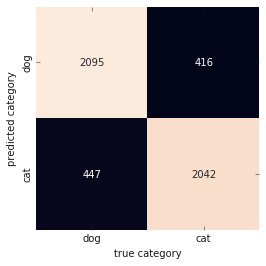

In [14]:
plt.style.use('classic')
%matplotlib inline

mat = confusion_matrix(y_test, predictions.round())
labels = ['dog', 'cat']

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('true category')
plt.ylabel('predicted category')

In [49]:
instances = 0
correct_ones = 0

images = x_test * 255
images = images.reshape(5000,64, 64)
incorrect_predictions = []

for i in range(0, len(predictions)):
    if i < 5:
        print("Prediction: ", predictions[i], ", Actual: ", y_test[i])
    if predictions[i].round() == y_test[i]:
        correct_ones += 1
    else:
        incorrect_predictions.append((i, images[i], predictions[i].round(4), y_test[i]))
    instances += 1
    
print('\nMade {amountPred} predictions. {amountCorrect} of those are correct. Approximately {percentage}%.'
      .format(amountPred=instances, amountCorrect=correct_ones, percentage=round((correct_ones/instances) * 100)))

Prediction:  [0.5145127] , Actual:  0
Prediction:  [0.56603503] , Actual:  0
Prediction:  [0.99702567] , Actual:  0
Prediction:  [4.35466e-07] , Actual:  0
Prediction:  [0.98181605] , Actual:  1

Made 5000 predictions. 4137 of those are correct. Approximately 83%.


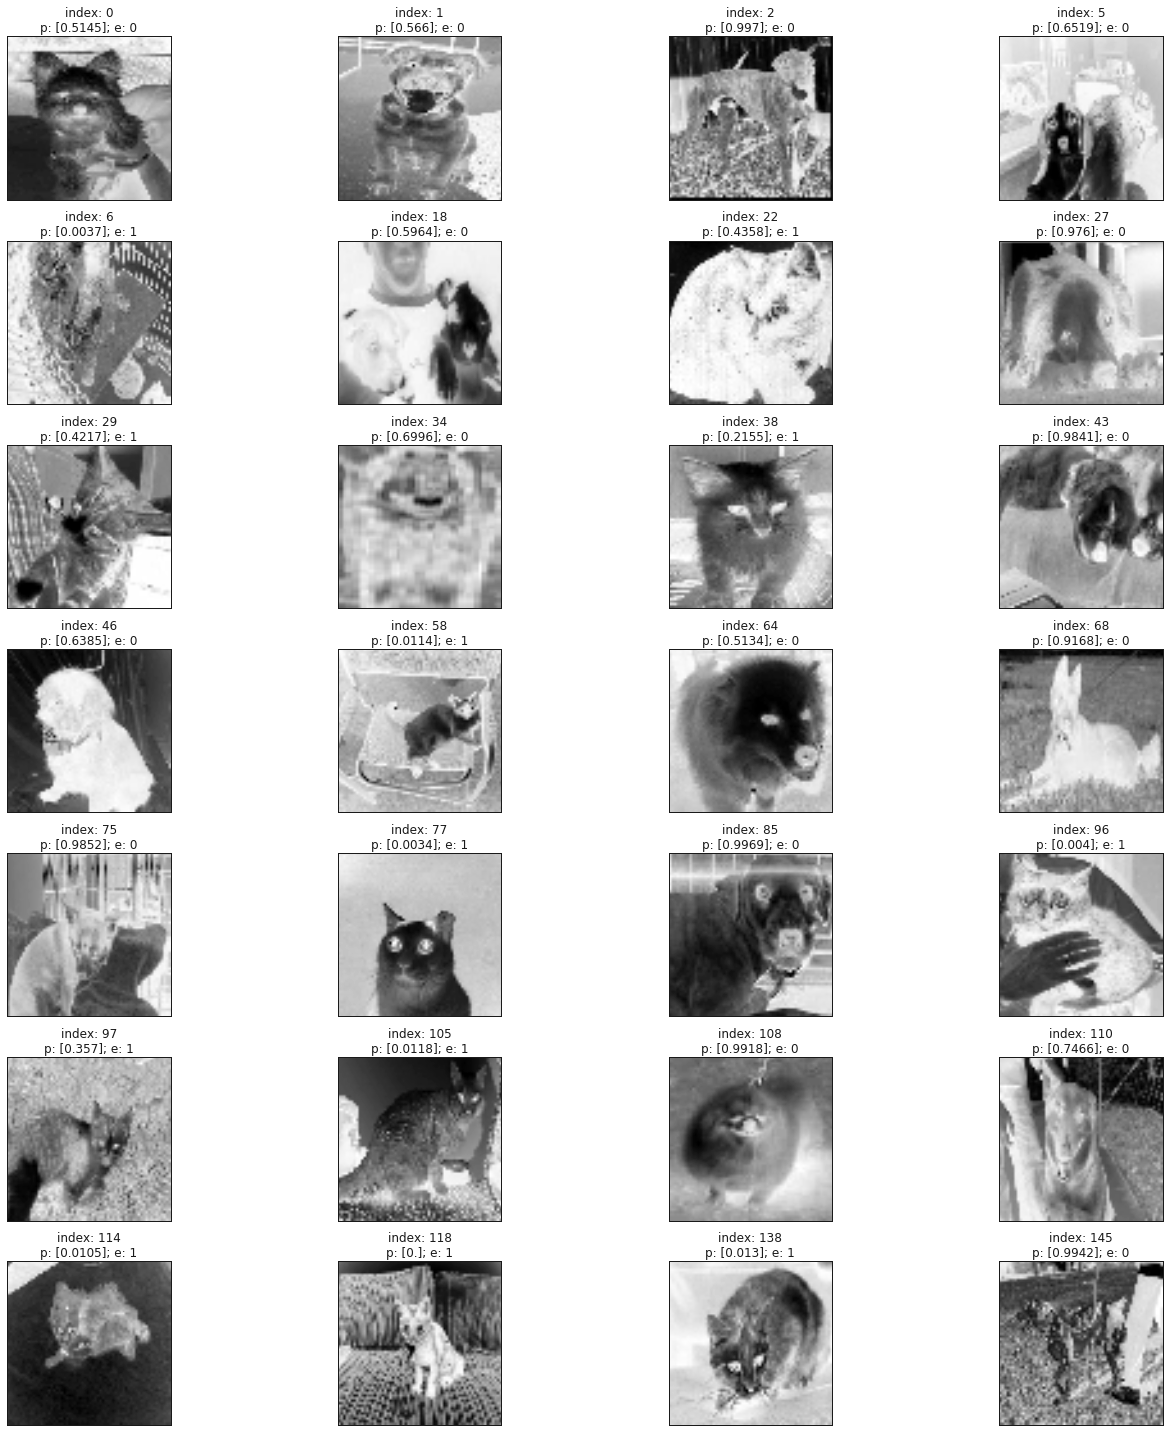

In [66]:
# Show images that are classified to the wrong class
# Dog = 0, Cat = 1
%matplotlib inline

figure, axes = plt.subplots(nrows=7, ncols=4, figsize=(20,20))

for axes, item in zip(axes.ravel(), incorrect_predictions):
    index, image, predicted, expected = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_title(f'index: {index}\np: {predicted}; e: {expected}')
plt.tight_layout()

In [67]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
normalization (Normalization (None, 64, 64, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0     

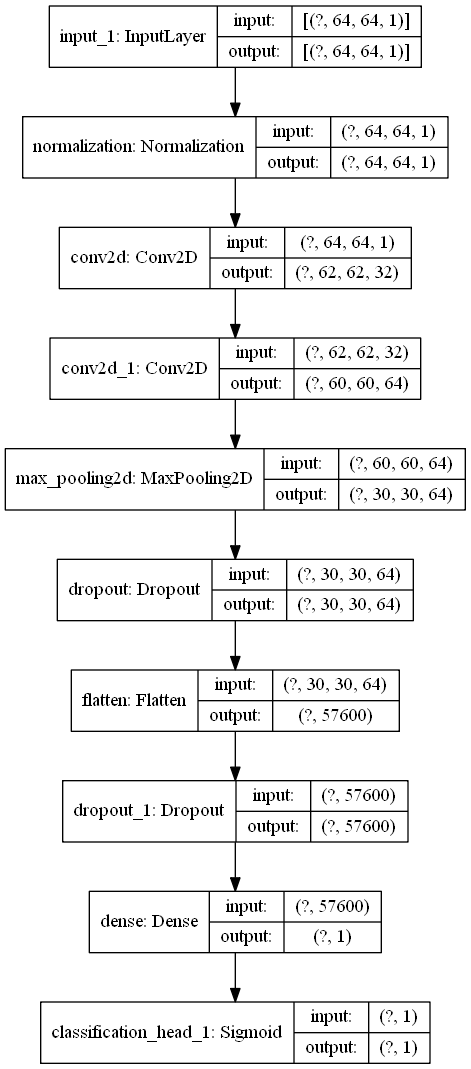

In [68]:
plot_model(model, to_file=OUTPUT_NAME + '/model.png', show_shapes=True, show_layer_names=True)